# Principal Component Analysis - Key Equities Driving S&P500

Equity and Fixed Income project

Authors: Adam Foster, Maciej Staniszewski

PCA is a dimensionality reduction method whereby multiple variables in a large dataset are transformed into a smaller set of variables, maintaining most of the information in the large dataset. Resulting variables are easier to explore and analyse and are less computationally expensive to process.

This exercise covers a practical demonstration of this approach, as well as its application in determining key single name equity drivers of the S&P500 index.

## Prerequisites

We recommend cloning the following Github repo to run this code locally and access the dataset used subsequently:
https://github.com/afoster28/efi-pca.git

Make sure to run the following command to install all required packages:
`pip install -r requirements.txt`

These include:
* `numpy` for basic mathematical operations
* `pandas` for dataset manipulations 
* `matplotlib` for data visualisation with plots
* `yfinance` for financial data

Dataset to be included in run folder (available on Github): `all_stocks_5yr.csv`

## PCA Details

### Step 1 - Standardisation

Standardisation involves the normalisation using mean and standard deviation and makes varying domains comparable. This prevents variables with larger domains dwarfing the impact of smaller domains, reducing bias.

$z = \frac{value - mean}{standard deviation}$

### Step 2 - Covariance Matrix

In searching for all possible relationships between the variables and their joint variance, a covariance matrix is created. For n variables, an $n\times n$ covariance matrix is formed.

We can observe a couple of interesting facts about the covariance matrix:
* Diagonal elements of the covariance matrix describe the variance of individual variables. This is because they contain information about the variability of the pair of values $(e1, e1)$ which is essentially the same as the variability of $e1$ for some variable $e1$.
* Another observation is that the matrix should be symmetrical about the diagonal. This means that elements $(e1, e2)$ vary in the same exact way as elements $(e2, e1)$. Note: that python libraries will raise a warning if the covariance matrix does not have that property.

### Step 3 - Eigendecomposition

Principal components are new variables that are constructed as linear combinations of the initial variables. These combinations are done in such a way that the principal components are uncorrelated and most of the information within the initial variables (and therefore the variance) is compressed into the first components.

Across all principal components, the same information is maintained. The advantage is that the minimum amount of information is lost when removing the least important components, hence a large proportion of the data can be represented in few components - they pick up the maximal amount of variance.

The first principal component is calculated to maximise the average of the squared distances from projected points to the origin. The second one is calculated the same way, provided it is uncorrelated with and therefore orthogonal to the first component. This can be continued for the number of dimensions of the data and each component has an associated eigenvector-eigenvalue pair. Eigenvectors described the direction of the axes where there is the most variance and eigenvalues show the amount of variance carried. Ranking eigenvectors by eigenvalues in descending order produces the principal components in order of significance. The eigenvalue relative to the sum of eigenvalues denotes the percentage of variance covered by the associated principal component.

#### Methodology

A point $x$ gets projected onto a unit vector $u$, a new point $x'$ is created whose magnitude is calculated by the inner product between $x$ and $u$: $x' = (x^{T}u)u$.

$(x^{T}u)^{2}$ can be thought of as the amount of information preserved and is maximal when $x$ is parallel to $u$ and minimal when $x$ is orthogonal to $u$. PCA is then an optimisation problem whereby it seeks to maximise information preserved subject to the unit vector usage:

$max \sum \limits _{i} (x _{i} ^{T} u)^{2}$ subject to $u^{T} u = 1$

which simplifies to

$max \text{ } u ^{T} C u$ subject to $u^{T} u = 1$ where $C = \frac{1}{n} \sum \limits _{i} x _{i} x _{i} ^{T}$ (covariance matrix)

This can be expressed as a Lagrangean and solved:

$L = u ^{T} C u - \lambda(u^{T} u - 1)$

$2 C u - 2 \lambda u = 0$

$C u = \lambda u$

Therefore, $u$ and $\lambda$ represent eigenvectors and eigenvalues, respectively. The best direction $u_{1}$ to pick is the eigenvector with the largest eigenvalue $\lambda_{1}$. $u_{2}$ can then be selected such that $u_{2} \perp u_{1}$ with $\lambda_{2}$ and so on.


### Step 4 - Feature Vector

At this stage, a process of elimination occurs based on principal component significance and the resulting components form the feature vector.


### Step 5 - Recast the Data along the PC Axes

Eigenvectors of the feature vector prinicpal components are used to reorient the data from the original axes to the ones represented by the principal components.

$Final Dataset = Feature Vector^{T} \times Standardised Original Dataset^{T}$

This data can be visualised in a more intuitive manner.


## Simple PCA Decomposition

In [21]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

We're now ready to use them to generate a simple dataset. We'll implement a data-generating function the results of which we'll be using as inputs to our PCA. 

The **aim of our exercise is to show, that results of principal components analysis align with theoretical, expected outcomes** for the dataset generated using the above function.

Our samples will be drawn from a Gaussian distribution in two dimensions, as follows:

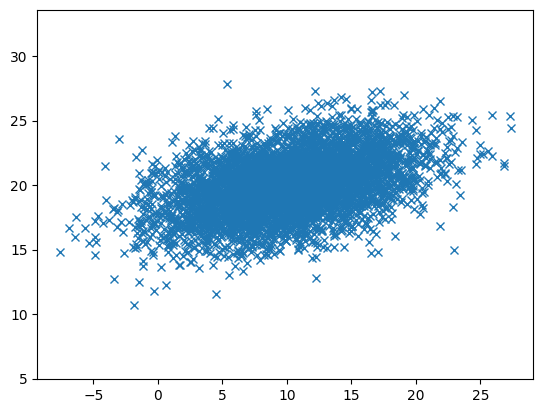

In [22]:
means = [10, 20]  # Means of marginal distributions
cov = [[25, 5], [5, 5]]  # diagonal covariance
x, y = np.random.multivariate_normal(means, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

PCA is based on eigenvalues and eigenvectors which can be computed using `numpy`:

In [23]:
values, vectors = np.linalg.eig(cov)
values[:5]

array([26.18033989,  3.81966011])

In [24]:
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
 
print(f"Total explained variance = {np.sum(explained_variances) * 100}%\nIndividual explained variances = {explained_variances}\n")

Total explained variance = 100.0%
Individual explained variances = [0.872677996249965, 0.12732200375003505]



We can see, that the variance is explained fully by the first two components. The first component explains over 87% of variance in the data. This is as expected, because the data was generated using two variables only. 

In [25]:
# Let's define a simple function that will format a vector for later printing
def print_vector(v):
    return( "({}, {})" ).format(round(v[ 0 ], 2), round(v[ 1 ], 2))

In [26]:
# Eigenvectors obtained through the decomposition:
for i, v in enumerate(zip( vectors, values )):
    # Using the small helper function defined above
    print( f"Eigenvector {i}:\t{print_vector(v[ 0 ])} with value {round(v[ 1 ], 2)}" )

Eigenvector 0:	(0.97, -0.23) with value 26.18
Eigenvector 1:	(0.23, 0.97) with value 3.82


These eigenvectors are two-dimensional. We can easily plot them over the original data set as follows:

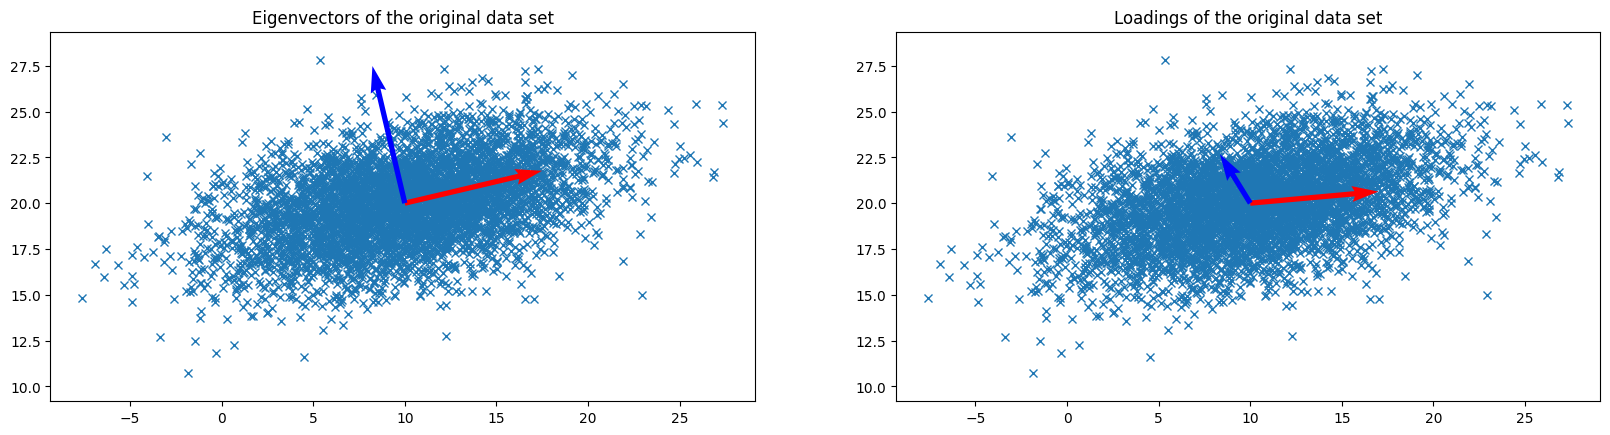

In [56]:
origin = [[means[0], means[0]], [means[1], means[1]]]

fig, ax = plt.subplots(nrows=1, ncols=2)

# Plotting actual eigenvectors on the left
ax[ 0 ].plot(x, y, 'x', zorder=1)
ax[ 0 ].axis('equal')
ax[ 0 ].set_title('Eigenvectors of the original data set')
ax[ 0 ].quiver(*origin, vectors[ 0 ], vectors[ 1 ], 
            color=['r','b'], scale=5, zorder=2)

# Plotting scaled eigenvectors - "loadings" on the right. For details see references.
ax[ 1 ].plot(x, y, 'x', zorder=1)
ax[ 1 ].axis('equal')
# Loadings are eigenvectors which are scaled by the square root of the explained variance 
ax[ 1 ].set_title('Loadings of the original data set')
ax[ 1 ].quiver(*origin, 
               np.dot( vectors[ 0 ], np.sqrt( explained_variances[ 0 ] ) ), 
               np.dot( vectors[ 1 ], np.sqrt( explained_variances[ 1 ] ) ), 
            color=['r','b'], scale=5, zorder=2)

fig.set_figwidth(20)
plt.show()

The first (red) eigenvector is in fact explaining most of the variance as computed above. The horizontal dispersion is dominant and receives more weight through the eigenvalue. The vertical dispersion is smaller in comparison and less important overall. Note, how the directions of eigenvectors appropriately reflect the tilt introduced by the correlation structure.

We will now download actual financial data observed in the market. That way we will observe the differences in PCA behavior between empirical data and data from the data generating process.

## Real-world Data

A good example of features varying together is a financial equity index. One of the most popular ones is the ***S&P500*** (*"Standard and Poor's 500"*). It measures cumulative performance of 500 selected largest US equity stocks that trade on the New York Stock Exchange. We will use PCA to explain the variability of this complex index by fewer stocks, that belong to this investment bucket. 

### Goal

Our goal is to show the individual stocks included in the S&P500 index that drive the overall variance the most.

### Dataset

We downloaded 5-year historical data containing information about stock prices of all S&P500 underliers as of February 2018 from Kaggle (link is in the References). We will use this dataset for our empirical study.

### Loading and Preparing the Dataset

Let's use `pandas` to load the dataset:

In [57]:
stocks = pd.read_csv('all_stocks_5yr.csv')
stocks.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [58]:
stocks.tail()

,date,open,high,low,close,volume,Name
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS
619039,2018-02-07,72.70,75.00,72.69,73.86,4534912,ZTS


We will be interested in the ***close*** column as it is a feature commonly used in the industry that offers accurate precision to reflect the stock price of a stock.

In [61]:
stocks = stocks[['date', 'close', 'Name']]
unique_names = pd.unique(stocks.loc[:,'Name'])

Let's now load the actual S&P500 prices for the same period:

In [62]:
import yfinance as yf
snp = yf.download("SPX", start="2013-02-08", end="2018-02-07")
snp.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-08,0.08306,0.08667,0.07944,0.08667,0.08667,489731
2013-02-11,0.09028,0.09028,0.08667,0.08667,0.08667,868053
2013-02-12,0.08306,0.08306,0.08306,0.08306,0.08306,473904
2013-02-13,0.07944,0.07944,0.07944,0.07944,0.07944,149173
2013-02-14,0.07583,0.07583,0.07583,0.07583,0.07583,57096


In [63]:
snp = snp[['Close']]
snp.tail()

,Close
Date,
2018-01-24,0.055
2018-01-25,0.055
2018-01-26,0.050
2018-01-29,0.050
2018-01-30,0.050


S&P data is not loaded for days between 2018-01-30 and 2018-02-07. We will trim individual stock prices scope to align with that limitation:

In [64]:
stocks = stocks[stocks['date'] <= '2018-01-30']
stocks.tail()

,date,close,Name
619029,2018-01-24,78.33,ZTS
619030,2018-01-25,79.25,ZTS
619031,2018-01-26,80.09,ZTS
619032,2018-01-29,79.18,ZTS
619033,2018-01-30,78.35,ZTS


We're ready for our decomposition now.

### Decomposition of the S&P500 Index - Covariance

The first step, as discussed before, is to obtain the covariance matrix. We cannot simply call `.cov()` on `stocks`, as all `close` values are in a single column spanning over all stocks that we have in the index. We need to re-pivot the data, so that every stock gets it's own `close` column with stock prices for all dates.

In [66]:
pivoted_stocks = pd.DataFrame(np.unique(stocks['date']), columns=['date'])
pivoted_stocks.set_index('date')
pivoted_stocks.head()

,date
0,2013-02-08
1,2013-02-11
2,2013-02-12
3,2013-02-13
4,2013-02-14


`pivoted_stocks` DataFrame defined above contains all possible unique dates. We will now try to extend this table with new columns for every stock name that we have. The `close` data will be joined to that table based on the date that we already put inside `pivoted_stocks`. 

If the code below is taking long (~60 seconds) to compute - **this can be expected** - the dataset we're trying to process is fairly large.

In [67]:
# Discussed in a comment inside the loop below
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for name in unique_names:                                                   # For all unique names that we have in the dataset
    prices_for_this_name = stocks[stocks['Name'] == name]                   # Find all prices for a given stock name 
    joined = pivoted_stocks.join(prices_for_this_name.set_index('date'),    # Join those individual stock prices with the list of unique dates
                                 on='date')
    pivoted_stocks[name] = joined['close'].values                           # Add a new column to the dataset with a name representing a stock
    
    #NOTE: Even though we get 'performance warnings', the above line is much much faster than the recommented pd.concat() below:
    #pivoted_stocks = pd.concat([pivoted_stocks, pd.Series(joined['close'].values, name=name)])

Finally, we can set `date` column as the index in the table and see how well it was populated:

In [68]:
pivoted_stocks.set_index('date', inplace=True)
pivoted_stocks.tail()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-24,54.79,174.22,120.99,105.51,104.62,61.72,160.60,197.78,95.34,42.84,...,73.48,36.86,88.53,61.83,32.36,72.57,85.24,125.02,53.74,78.33
2018-01-25,53.05,171.11,120.92,108.30,104.37,63.22,160.79,197.51,91.98,42.89,...,69.74,36.88,88.37,62.81,32.38,73.24,85.66,124.74,53.02,79.25
2018-01-26,53.07,171.51,123.64,123.21,105.48,63.42,162.55,201.30,93.84,43.59,...,71.94,36.67,89.00,62.84,32.83,74.41,86.20,126.23,54.02,80.09
2018-01-29,52.68,167.96,122.89,122.31,105.09,63.31,161.19,198.23,93.78,43.11,...,72.18,36.61,88.01,61.98,32.84,73.41,86.48,127.39,54.19,79.18
2018-01-30,52.59,166.97,119.27,115.88,102.46,62.44,159.70,196.90,91.55,42.48,...,72.13,36.62,86.78,61.40,32.68,73.07,84.59,125.94,53.93,78.35


Everything is in appropriate format. We're ready to compute the covariance matrix for this data.

In [69]:
stocks_cov = pivoted_stocks.cov()
stocks_cov.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
AAL,119.727738,277.407079,185.796113,105.861610,137.990262,47.880243,150.018379,272.216231,100.378644,33.442975,...,56.625134,30.944707,-23.385670,55.300925,1.317969,77.913452,17.561612,126.678990,42.460594,89.720164
AAPL,277.407079,924.384017,258.468333,360.865901,333.926329,156.400493,562.295844,1002.255254,368.772470,62.774588,...,217.670907,99.017974,-110.963420,177.818933,-84.590851,280.960122,55.647463,355.006680,172.564283,333.741735
AAP,185.796113,258.468333,980.985423,61.563011,361.104540,31.648674,141.734285,116.280853,46.795886,85.390854,...,-29.514097,40.309176,-50.909894,112.659905,59.045137,17.390001,59.118289,237.942358,-30.973879,72.880262
ABBV,105.861610,360.865901,61.563011,176.307508,119.089854,70.080151,246.163186,431.514309,150.043284,23.495730,...,96.278642,32.361491,-34.236004,72.697634,-32.188048,128.126826,37.507356,144.616520,73.900316,140.873427
ABC,137.990262,333.926329,361.104540,119.089854,266.569915,63.884966,155.255950,247.723515,96.807742,46.750471,...,28.230339,41.202376,-55.625984,71.207174,16.859706,52.933427,55.642725,165.063180,21.219472,106.979719


### Decomposition of the S&P500 Index - Eigendecomposition

Now for the best part - obtaining the eigenvectors from the covariance matrix above:

In [70]:
eigenvalues, eigenvectors = np.linalg.eig(stocks_cov)

In [71]:
# Eigenvectors obtained through the decomposition:
for i, v in enumerate(zip( eigenvectors, eigenvalues )):
    # Using the small helper function defined above
    print( f"Eigenvector {i}:\t{print_vector(v[ 0 ])} with value {round(v[ 1 ], 2)}" )

Eigenvector 0:	(0.01, 0.03) with value 396555.09
Eigenvector 1:	(0.04, 0.03) with value 54837.35
Eigenvector 2:	(0.01, 0.12) with value 27631.41
Eigenvector 3:	(0.02, 0.01) with value 10831.05
Eigenvector 4:	(0.01, 0.06) with value 6526.9
Eigenvector 5:	(0.01, 0.01) with value 4946.43
Eigenvector 6:	(0.03, -0.0) with value -4198.29
Eigenvector 7:	(0.06, -0.01) with value 2488.8
Eigenvector 8:	(0.02, -0.0) with value 1856.27
Eigenvector 9:	(0.0, 0.02) with value 1495.81
Eigenvector 10:	(0.02, 0.0) with value 1049.43
Eigenvector 11:	(0.03, -0.01) with value -910.88
Eigenvector 12:	(0.01, 0.12) with value 819.61
Eigenvector 13:	(0.01, -0.0) with value 650.35
Eigenvector 14:	(0.01, 0.0) with value 624.46
Eigenvector 15:	(-0.0, 0.0) with value 497.88
Eigenvector 16:	(0.05, 0.02) with value -366.71
Eigenvector 17:	(0.01, -0.01) with value 430.41
Eigenvector 18:	(0.02, 0.23) with value 399.45
Eigenvector 19:	(0.01, 0.01) with value 377.7
Eigenvector 20:	(0.01, 0.01) with value 314.21
Eigenvec

The eigenvectors above are sorted in order of decreasing absolute value of the respective eigenvalue.

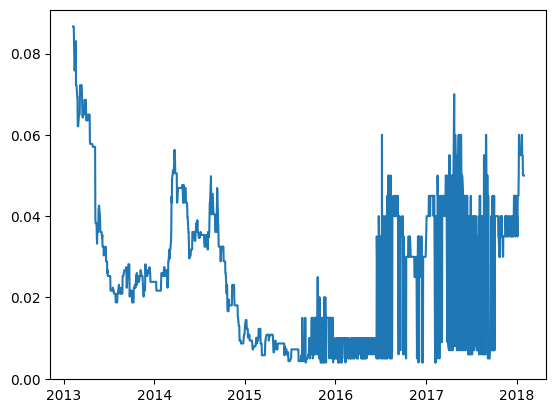

In [73]:
# Clear plot area
plt.cla()
plt.clf()

plt.plot(snp)

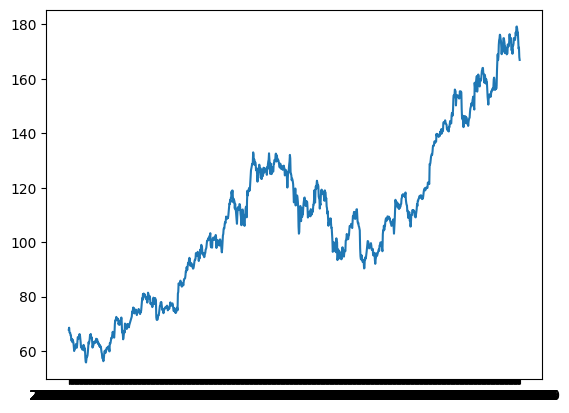

In [74]:
# Clear plot area
plt.cla()
plt.clf()

plt.plot(pivoted_stocks['AAPL'])

ValueError: Argument V has a size 5 which does not match 10, the number of arrow positions

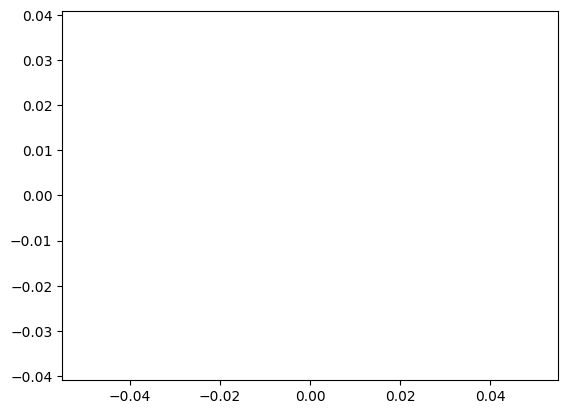

In [72]:
# Plotting top 5 (by abs(eigenvalue)) eigenvectors
origin = np.zeros(shape=(5, 2))

# Clear plot area
plt.cla()
plt.clf()

plt.axis('equal')

x = [ v[ 0 ] for v in eigenvectors[0:5] ]
y = [ v[ 1 ] for v in eigenvectors[0:5] ]
plt.quiver(np.zeros(shape=(5, 2)), x, y,
            color=[ 'b', 'b', 'b', 'b', 'b' ], scale=5, zorder=2)

#plt.set_figwidth(20)
plt.show()

We will apply the PCA methodology to equity prices, particularly in decomposing the pair relationships between multiple equities and their broader indices. Fundamentally, carving out the market component from the idiosyncratic one can demonstrate the varying impact of risk factors on the price of equities. The results are informative in nature, but can provide insight into expected moves of single name equities based on their index changes.

## Findings


## References
* https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51
* https://stats.stackexchange.com/questions/143905/loadings-vs-eigenvectors-in-pca-when-to-use-one-or-another
* https://www.kaggle.com/datasets/camnugent/sandp500
* https://builtin.com/data-science/step-step-explanation-principal-component-analysis